<a href="https://colab.research.google.com/github/magotronico/DataAnalysis_and_AI/blob/main/dmx_challenge/dmx_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DmX Challenge: Company Policies to Maximize Branch Income


**Overview**

This notebook is designed to analyze the efficiency of each branch and its associated salesmen using the data provided by DmX. The primary goal of this analysis is to extract valuable insights that can help in assessing and improving operational performance across different branches.

**Process**

This project involves implementing an **ETL (Extract, Transform, Load) pipeline**. The pipeline is responsible for:

1.   **Extracting** the raw data from CSV files.
2.   **Transforming** the data into a structured and insightful format.
3.   **Loading** the processed data back into CSV files for further analysis or reporting.

By the end of this notebook, you'll have a clear understanding of how each branch and salesman perform, allowing for data-driven decision-making to enhance overall efficiency.



---
Instituto Tecnológico y de Estudios Superiores de Monterrey

Analítica de datos y herramientas de inteligencia artificial TI3001C.103

Profesor: Enrique Ricardo García Hernández

Equipo 2:
*   Dilan González Castañeda             A00831905
*   Karim Omar Martínez Bazaldúa         A00832999
*   André Ulises Zenteno Ruiz            A00835044
*   Carolina Glorisel Murillo Guajardo   A00834868



## Extract


**Data Overview**

DmX provided an `.xlsx` file containing financial data for the previous 12 months and the current month. The dataset includes the following categories:

*   **Saldo Insoluto:** The outstanding balance of loans or credits that have not yet been paid off.
*   **Saldo Insoluto Vencido:** The overdue portion of the outstanding balance that has not been paid by the due date in 12 months.
Pago Anticipado: The amount of money that has been paid ahead of schedule.
*   **Capital Liquidado:** The amount of capital that has been fully paid off.
*   **Capital Dispersado:** The amount of capital that has been distributed by the company.
*   **Quitas:** A reduction in the debt amount negotiated with the client when full recovery is unlikely.
*   **Castigos:** The formal recognition of uncollectible debt that is written off the financial records.

The `.xlsx `file was not structured in a way that was easily compatible with Python and pandas. Therefore, we converted the file to .csv format to facilitate data analysis and manipulation.

In [ ]:
%pip install unidecode

In [ ]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler

file_name = '/content/Indicadores_reto_AD24.csv'

In [ ]:
# Load original DataBase (csv)
df = pd.read_csv(file_name, encoding='utf-8')
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Columns: 181 entries, Región to Quitas Actual
dtypes: float64(167), object(14)
memory usage: 14.3+ MB


## Transform


### Drop empty column and Columns Standardization

In [ ]:
# Original DB includes an empty column
df.drop(columns=['Unnamed: 2'], inplace=True)

# The column region in reality includes sucursales so it need to be renamed
df.rename(columns={'Región': 'sucursal'}, inplace=True)
df['sucursal'] = df['sucursal'].apply(unidecode)
df.head()

,sucursal,Vendedor,Saldo Insoluto T-12,Saldo Insoluto T-11,Saldo Insoluto T-10,Saldo Insoluto T-09,Saldo Insoluto T-08,Saldo Insoluto T-07,Saldo Insoluto T-06,Saldo Insoluto T-05,...,Quitas T-09,Quitas T-08,Quitas T-07,Quitas T-06,Quitas T-05,Quitas T-04,Quitas T-03,Quitas T-02,Quitas T-01,Quitas Actual
0,Centro Metropolis,MAA_6289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1488.00,0.02
1,Centro Metropolis,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1488.00,0.02
2,Conexion Magna,MAG_7191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.02,1913.46,-0.01
3,Conexion Magna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.02,1913.46,-0.01
4,Enlace Regio,ALM_0607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2794.28,NaN,NaN


**Explanation:**
* **Lowercase and Underscores:** The lower() method converts all characters to lowercase, and replace() is used to replace spaces and special characters with underscores.

* **Acronyms:** Common phrases are replaced with shorter acronyms (e.g., saldo_insoluto becomes si, vencido becomes vnc, etc.).

* **Time Series Handling:** T-12, T-11, etc., are replaced with m_12, m_11, and so on, to indicate months.

---
**Example Column Renaming:**
* 'Región' → 'region'
* 'Saldo Insoluto T-12' → 'si_m_12'
* 'Saldo Insoluto Actual' → 'si_act'
* 'Pago Anticipado T-12' → 'pa_m_12'
* 'Castigos T-12' → 'cst_m_12'

In [ ]:
def rename_column(col):
    # Replace spaces and special characters
    col = col.lower().replace(' ', '_').replace('\n', '').replace('-', '_').replace('%', 'pct')

    # Create a dictionary for common term replacements
    replacements = {
        'saldo_insoluto': 'si',
        'vencido': 'vnc',
        'actual': 'act',
        'pago_anticipado': 'pa',
        'capital_liquidado': 'cl',
        'capital_dispersado': 'cd',
        'quitas': 'qts',
        'castigos': 'cst'
    }

    # Replace common terms
    for old, new in replacements.items():
        col = col.replace(old, new)

    # Handle time series (T-12, T-11,..., T-01, Actual)
    if '_t_' in col:
        col = col.replace('_t_', '_m_')

    # Map specific time series columns
    column_mapping = {
        'cst_ago_22': 'cst_m_23',
        'cst_sep_22': 'cst_m_22',
        'cst_oct_22': 'cst_m_21',
        'cst_nov_22': 'cst_m_20',
        'cst_dic_22': 'cst_m_19',
        'cst_ene_23': 'cst_m_18',
        'cst_feb_23': 'cst_m_17',
        'cst_mar_23': 'cst_m_16',
        'cst_abr_23': 'cst_m_15',
        'cst_may_23': 'cst_m_14',
        'cst_jun_23': 'cst_m_13'
    }

    # Apply the mapping
    if col in column_mapping:
        col = column_mapping[col]

    # Ensure no double underscores
    col = col.replace('__', '_')

    return col

# Apply renaming function to all columns
df.columns = [rename_column(col) for col in df.columns]

# Print new column names
print([col for col in df.columns])


['sucursal', 'vendedor', 'si_m_12', 'si_m_11', 'si_m_10', 'si_m_09', 'si_m_08', 'si_m_07', 'si_m_06', 'si_m_05', 'si_m_04', 'si_m_03', 'si_m_02', 'si_m_1', 'si_act', 'si_vnc_m_12', 'si_vnc_m_11', 'si_vnc_m_10', 'si_vnc_m_09', 'si_vnc_m_08', 'si_vnc_m_07', 'si_vnc_m_06', 'si_vnc_m_05', 'si_vnc_m_04', 'si_vnc_m_03', 'si_vnc_m_02', 'si_vnc_m_01', 'si_vnc_act', 'si_30_89_m_12', 'si_30_89_m_11', 'si_30_89_m_10', 'si_30_89_m_09', 'si_30_89_m_08', 'si_30_89_m_07', 'si_30_89_m_06', 'si_30_89_m_05', 'si_30_89_m_04', 'si_30_89_m_03', 'si_30_89_m_02', 'si_30_89_m_01', 'si_30_89_act', 'saldo_60_en_6_m_12', 'saldo_60_en_6_m_11', 'saldo_60_en_6_m_10', 'saldo_60_en_6_m_09', 'saldo_60_en_6_m_08', 'saldo_60_en_6_m_07', 'saldo_60_en_6_m_06', 'saldo_60_en_6_m_05', 'saldo_60_en_6_m_04', 'saldo_60_en_6_m_03', 'saldo_60_en_6_m_02', 'saldo_60_en_6_m_01', 'saldo_60_en_6_act', 'cst_m_23', 'cst_m_22', 'cst_m_21', 'cst_m_20', 'cst_m_19', 'cst_m_18', 'cst_m_17', 'cst_m_16', 'cst_m_15', 'cst_m_14', 'cst_m_13', 'cs

### Merge branches

#### Aux to split region column

In [ ]:
regions = ["Brokers", "Nucleo Uno", "Nucleo Dos", "Red Nortena", "Red Noroeste", "Occidente Conexion", "Red Sureste"]

divisions = [
    "Division. Red Mexiquense", "Conexion Naucalpan", "Zona Sur Central",
    "Zona Oriente Valle", "Zona Norte Valle", "Division. Distrito Central",
    "Nucleo Avance", "Zona Nucleo CDMX", "Zona Oriente Conexion",
    "Zona Cordillera Puebla", "Zona Bahia Veracruz", "Division Red Nortena",
    "Zona Sierra Norte", "Zona Red frontera este", "Zona Bahia del Sol",
    "Division Sierra del Desierto", "Zona Costa del Pacifico",
    "Zona Valle Dorado", "Zona Desierto del Sol", "Conexion GDL",
    "Zona Corazon de la Sierra", "Zona Valles Centrales", "Zona Tierra de lagos", "Zona Cumbres del Pacifico", "Zona Valles del Pacifico", "Zona Selva Alta", "Zona Sierra Escondida", "Zona Riviera del Caribe"
]

branches = [
    "Centro Metropolis", "Conexion Magna", "Enlace Regio", "Puerto Magna",
    "Ciudad Piramide", "Valle Verde", "Rio Blanco", "Colina del Sol",
    "Colina del Sol BIS", "Parque Jurica", "Colina Plateada", "Altos de Queretaro", "Sol y Campo", "Satélite 1", "Satélite 2", "Satélite 3", "Bahia Dorada", "Costa Marquesa", "Bahia Dorada BIS", "Alto de Chilpan", "Cuautla Vista", "Jardines del Valle", "Llanos de Igualdad", "Parque Jojutla",
    "Valle Chalco", "Montana Azul", "Reyes Paz A", "Reyes Paz B",
    "Bosques Neza", "Cumbre Neza", "Cumbre Neza BIS", "Riberas Texcoco",
    "Pinar del Valle", "Cielos de Metepec", "Lomas de Naucalpan",
    "Puente de Tlalne", "Puente de Tlalne II", "Valles Toluca",
    "Cumbre Toluca", "Bosques Tultitlan", "Jardin Aragon A",
    "Pilares del Norte", "Pilares del Norte BIS", "Residencia A",
    "Residencia B", "Colinas GAM", "Plaza Central", "Los Arcos",
    "Los Arcos BIS", "Campo Zaragoza", "Lomas Zaragoza", "Campo Zaragoza BIS",
    "Avance 1", "Avance 2", "Avance 3", "Avance 4", "Parque Obregon",
    "Centro Viejo", "Mirador Tlalpan A", "Mirador Tlalpan A BIS",
    "Mirador Tlalpan B", "Lagunas de Xochimilco", "Plaza Zapata",
    "Robledal A", "Robledal B", "Campo Florido A", "Campo Florido B",
    "Campo Florido C", "Campo Florido D", "Riberas del Sur",
    "Sierra Cordobesa", "Valles de Orizaba", "Alturas de Puebla",
    "Jardines Manuel", "Lomas Santiago", "Alturas de Puebla BIS",
    "Llanos Tehuacan", "Bosques Tlaxcala", "Colinas Miron",
    "Valle Rica", "Puerto Bravo", "Puerta Cuauhtemoc", "Puerto Bravo BIS",
    "Cumbres Xalapa", "Lomas Xalapa", "Paso del Norte", "Rio Bravo",
    "Aceros del Norte", "Aceros del Norte BIS", "Paso Nuevo",
    "Paso Nuevo BIS", "Piedras Altas", "Piedras Altas BIS", "Valles del Norte",
    "Laguna Norte", "Sabinas Sierra", "Campos Saltillo", "Centro Saltillo",
    "Centro Saltillo BIS", "Campos Saltillo BIS", "Lomas de Alamos",
    "Lomas de Alamos BIS", "Valle Apodaca", "Valle Apodaca BIS",
    "Puente Lincoln", "Cumbres Regias", "Centro Regio", "Bulevar Regio",
    "San Nicolas Valle", "San Nicolas Valle BIS", "Sierra Santa",
    "Bosque Verde", "Palacio del Norte", "Palacio del Norte BIS",
    "Valle de Guadalupe", "Parque Madero", "Parque Madero BIS",
    "Expo Regia", "Desierto Norte", "Desierto Bravo", "Rio Revolucion",
    "Desierto Norte BIS", "Valle Real", "Victoria Alta", "Victoria Alta BIS",
    "Bahia Aeropuerto", "Plaza Tampico", "Colinas Tampico",
    "Colinas Tampico BIS", "Rio Madero", "Sierra Chihuahua",
    "Campus Sierra", "Victoria Sierra", "Victoria Sierra BIS",
    "Plaza Cuauhtemoc", "Juarez Norte", "Jardines del Norte",
    "Americas Plaza", "Americas Plaza BIS", "Patio Grande",
    "Colinas Jilotepec", "Parral Viejo", "Bahia Azul", "Bahia Azul BIS",
    "Plaza Pacifico", "Plaza Pacifico BIS", "Cabo Fuerte", "Valle Mexicali",
    "Norte Mexicali", "Valle Mexicali BIS", "Frontera Oeste",
    "Frontera Bravo", "Frontera Bravo BIS", "Valles de Culiacan",
    "Culiacan Norte", "Valles de Culiacan BIS", "Sierra Durango",
    "Durango Norte", "Valle del Rio", "Plaza Mochis", "Plaza Mochis BIS",
    "Norte Dorado", "Obregon Central", "Obregon Norte", "Obregon Central BIS",
    "Sierra Hermosillo", "Hermosillo Norte", "Sierra Hermosillo BIS",
    "Valle de Navojoa", "Frontera Nogales", "Guadalajara Uno",
    "Guadalajara Dos", "Guadalajara Tres", "Aguas Central",
    "Aguas Norte", "Aguas Central BIS", "Sierra Colima", "Rio Fresnillo",
    "Bahia Manzanillo", "San Luis Norte", "San Luis Alturas",
    "Cumbres Zacatecas", "Plaza Celaya", "Hidalgo Valle",
    "Jardines Irapuato", "Jardines Irapuato BIS", "Canadas Leon",
    "Norte Leon", "Canadas Leon BIS", "Valle Piedad", "Bahia Lazaro",
    "Colinas Morelia", "Morelia Norte", "Morelia Norte BIS",
    "Camelinas Plaza", "Jardines Uruapan", "Valle Zamora",
    "Valle Zamora BIS", "Riviera Zihua", "Montes Zitacuaro",
    "GDL Central", "Norte GDL", "Riviera Vallarta", "Riviera Vallarta BIS",
    "Valle Tepic", "Norte Tepic", "Jardines Tlaque", "Montes Tonala",
    "Guzman Valle", "IMSS GDL", "Oblatos Plaza", "Las Aguilas",
    "Zapopan Plaza", "Rio Coatzacoalcos", "Valle Comitan",
    "Selva Tapachula", "Tuxtla Norte", "Tuxtla Central", "Villa Central",
    "Villa Norte", "Villa Norte BIS", "Villa Alturas", "Sierra Oaxaca",
    "Riviera Escondida", "Bahia Cruz", "Bahia Cruz BIS", "Rio Tuxtepec",
    "Bahia Campeche", "Riviera Cancun", "Bahia Chetumal",
    "Isla del Carmen", "Sierra Merida", "Merida Norte", "Alturas Merida",
    "Sierra Merida BIS", "Riviera Playa"
]

for branch in branches:
  if 'BIS' in branch:
    branches.remove(branch)

print(len(branches), len(divisions), len(regions))

196 28 7


In [ ]:
loc_struct = {
    "Brokers": ["Centro Metropolis", "Conexion Magna", "Enlace Regio", "Puerto Magna"],
    "Nucleo Uno": {
        "Division. Red Mexiquense": ["Ciudad Piramide", "Valle Verde", "Rio Blanco", "Colina del Sol",
                                     "Colina del Sol BIS", "Parque Jurica", "Colina Plateada",
                                     "Altos de Queretaro", "Sol y Campo"],
        "Conexion Naucalpan": ["Satelite 1", "Satelite 2", "Satelite 3"],
        "Zona Sur Central": ["Bahia Dorada", "Costa Marquesa", "Bahia Dorada BIS", "Alto de Chilpan",
                             "Cuautla Vista", "Jardines del Valle", "Llanos de Igualdad", "Parque Jojutla"],
        "Zona Oriente Valle": ["Valle Chalco", "Montana Azul", "Reyes Paz A", "Reyes Paz B",
                               "Bosques Neza", "Cumbre Neza", "Cumbre Neza BIS", "Riberas Texcoco"],
        "Zona Norte Valle": ["Pinar del Valle", "Cielos de Metepec", "Lomas de Naucalpan",
                             "Puente de Tlalne", "Puente de Tlalne II", "Valles Toluca",
                             "Cumbre Toluca", "Bosques Tultitlan"]
    },
    "Nucleo Dos": {
        "Division. Distrito Central": ["Jardin Aragon A", "Pilares del Norte", "Pilares del Norte BIS",
                                       "Residencia A", "Residencia B", "Colinas GAM", "Plaza Central",
                                       "Los Arcos", "Los Arcos BIS", "Campo Zaragoza", "Lomas Zaragoza",
                                       "Campo Zaragoza BIS"],
        "Nucleo Avance": ["Avance 1", "Avance 2", "Avance 3", "Avance 4"],
        "Zona Nucleo CDMX": ["Parque Obregon", "Centro Viejo", "Mirador Tlalpan A", "Mirador Tlalpan A BIS",
                             "Mirador Tlalpan B", "Lagunas de Xochimilco", "Plaza Zapata"],
        "Zona Oriente Conexion": ["Robledal A", "Robledal B", "Campo Florido A",
                                  "Campo Florido B", "Campo Florido C", "Campo Florido D",
                                  "Riberas del Sur"],
        "Zona Cordillera Puebla": ["Sierra Cordobesa", "Valles de Orizaba", "Alturas de Puebla",
                                   "Jardines Manuel", "Lomas Santiago", "Alturas de Puebla BIS",
                                   "Llanos Tehuacan", "Bosques Tlaxcala"],
        "Zona Bahia Veracruz": ["Colinas Miron", "Valle Rica", "Puerto Bravo", "Puerta Cuauhtemoc", "Puerto Bravo BIS", "Cumbres Xalapa", "Lomas Xalapa"]
    },

    "Red Nortena": {
        "Division Red Nortena": ["Aceros del Norte", "Aceros del Norte BIS", "Paso Nuevo", "Paso Nuevo BIS",
                                 "Piedras Altas", "Piedras Altas BIS", "Valles del Norte",
                                 "Laguna Norte", "Sabinas Sierra", "Campos Saltillo",
                                 "Centro Saltillo", "Centro Saltillo BIS", "Campos Saltillo BIS", "Rio Bravo", "Paso del Norte"],

        "Zona Sierra Norte": ["Lomas de Alamos", "Lomas de alamos BIS", "Valle Apodaca", "Valle Apodaca BIS", "Puente Lincoln", "Cumbres Regias", "Centro Regio",
                              "Bulevar Regio", "San Nicolas Valle", "San Nicolas Valles BIS", "Sierra Santa"],
        "Zona Red frontera este": ["Bosque Verde", "Palacio del Norte", "Palacio del Norte BIS", "Valle de Guadalupe", "Parque Madero", "Parque Madero BIS", "Expo Regia",
                                   "Desierto Norte", "Desierto Bravo", "Rio Revolucion", "Desierto Norte BIS"],
        "Zona Bahia del Sol": ["Valle Real", "Victoria Alta", "Victoria Alta BIS", "Bahia Aeropuerto",
                               "Plaza Tampico", "Colinas Tampico", "Colinas Tampico BIS", "Rio Madero"]
    },

    "Red Noroeste": {
        "Zona Desierto del Sol": ["Obregon Central", "Obregon Norte", "Obregon Central BIS",
                                  "Sierra Hermosillo", "Hermosillo Norte", "Sierra Hermosillo BIS", "Valle de Navojoa",
                                  "Frontera Nogales"],
        "Zona Valle Dorado": ["Valles de Culiacan", "Culiacan Norte", "Valles de Culiacan BIS", "Sierra Durango",
                              "Durango Norte", "Valle del Rio", "Plaza Mochis", "Plaza Mochis BIS", "Bahia Dorada", "Norte Dorado"],
        "Zona Costa del Pacifico": ["Bahia Azul", "Bahia Azul BIS", "Plaza Pacifico", "Plaza Pacifico BIS",
                                    "Cabo Fuerte", "Valle Mexicali", "Norte Mexicali", "Valle Mexicali BIS", "Frontera Oeste",
                                    "Frontera Bravo", "Frontera Bravo BIS"],
        "Division Sierra del Desierto": ["Sierra Chihuahua", "Campus Sierra", "Victoria Sierra",
                                         "Victoria Sierra BIS", "Plaza Cuauhtemoc", "Juarez Norte", "Jardines del Norte", "Americas Plaza",
                                         "Americas Plaza BIS", "Patio Grande", "Colinas Jilotepec", "Parral Viejo"]
    },

    "Occidente Conexion": {
        "Conexion GDL": ["Guadalajara Uno", "Guadalajara Dos", "Guadalajara Tres"],
        "Zona Corazon de la Sierra": ["Aguas Central", "Aguas Norte", "Aguas Central BIS", "Sierra Colima",
                                      "Rio Fresnillo", "Bahia Manzanillo", "San Luis Norte", "San Luis Alturas", "Cumbres Zacatecas"],
        "Zona Valles Centrales": ["Plaza Celaya", "Hidalgo Valle", "Jardines Irapuato", "Jardines Irapuato BIS",
                                  "Canadas Leon", "Norte Leon", "Canadas Leon BIS"],
        "Zona Tierra de lagos": ["Valle Piedad", "Bahia Lazaro", "Colinas Morelia", "Morelia Norte", "Morelia Norte BIS",
                                 "Camelinas Plaza", "Jardines Uruapan", "Valle Zamora",
                                 "Valle Zamora BIS", "Riviera Zihua", "Montes Zitacuaro"],
        "Zona Cumbres del Pacifico": ["GDL Central", "Norte GDL", "Riviera Vallarta", "Riviera Vallarta BIS",
                                      "Valle Tepic", "Norte Tepic", "Jardines Tlaque", "Montes Tonala"],
        "Zona Valles del Pacifico": ["Guzman Valle", "IMSS GDL", "Oblatos Plaza",
                                     "Las Aguilas", "Zapopan Plaza"]
    },
    "Red Sureste": {
        "Zona Selva Alta": ["Rio Coatzacoalcos", "Valle Comitan", "Selva Tapachula", "Tuxtla Norte", "Tuxtla Central",
                            "Villa Central", "Villa Norte", "Villa Norte BIS", "Villa Alturas"],
        "Zona Sierra Escondida": ["Sierra Oaxaca", "Riviera Escondida", "Bahia Cruz", "Bahia Cruz BIS", "Rio Tuxtepec"],
        "Zona Riviera del Caribe": ["Bahia Campeche", "Riviera Cancun", "Bahia Chetumal", "Isla del Carmen",
                                   "Sierra Merida", "Merida Norte", "Alturas Merida", "Sierra Merida BIS",
                                   "Riviera Playa"],
    },
}


#### Converge 'BIS'

In [ ]:
# Step 1: Leave min unit (vendedores)
filtered_df = df[df['sucursal'] != 'Total']
filtered_df = filtered_df[~filtered_df['sucursal'].isin(regions)]
filtered_df = filtered_df[~filtered_df['sucursal'].isin(divisions)]

# Step 2: Combine " BIS" with corresponding non-BIS values
filtered_df['sucursal'] = filtered_df['sucursal'].apply(lambda x: x.replace(' BIS', ''))

# Step 3: Delete row with region but without vendor
# is a 'Vendedor' to check for non-null values
filtered_df = filtered_df[filtered_df['vendedor'].notna()]

### Inactive and new susucrsals


The code for this part is strictely related to the definition of what do we consider as an Inactive and New Sucursal.


*   **New Sucursal**: A sucursal which has `cd` in the last 6 montns (`cd_m_05` - `cd_act`).
*   **Inactive Sucursal**: A sucursal which does not have cd on `cd_act`.

For this block, we have as input `filtered_df` and return other important 3: `new_sucursals`, `inactive_sucursals`, `old_active_sucursals_df`.


In [ ]:
# # Create a dir to store all inspection files
# if not os.path.exists('new_inactive'):
#   os.makedirs('new_inactive')

# First, make a df by sucursals dropping division, vendedor and region
df_sucursales = filtered_df.drop(columns=['vendedor'])

# Group that df by sucursal
df_sucursales = df_sucursales.groupby('sucursal').sum().reset_index()
print('T. Sucursals:', len(df_sucursales), '\n')
# df_sucursales.to_csv('new_inactive/df_sucursales.csv', index=False)

# Count the amount of sucursals with no cd on cd_act
inactive_sucursals = df_sucursales[df_sucursales['cd_act'] == 0]
print('T. Inactive Sucursals:', len(inactive_sucursals))
print('Inactive Sucursals:', [sucursal for sucursal in inactive_sucursals['sucursal']], '\n')

# Count the amount of sucursals with cd in the last 6 months
new_sucursals = df_sucursales[(df_sucursales['cd_m_06'] == 0) & (df_sucursales['cd_act'] > 0)]
print('T. New Sucursals:', len(new_sucursals))
print('New Sucursals:', [sucursal for sucursal in new_sucursals['sucursal']], '\n')

# New DataFrame with significant sucursals
old_active_sucursals_df = df_sucursales[~df_sucursales['sucursal'].isin(inactive_sucursals['sucursal']) & ~df_sucursales['sucursal'].isin(new_sucursals['sucursal'])].reset_index()
print('T. Old Active Sucursals:', len(old_active_sucursals_df))
# old_active_sucursals_df.to_csv('new_inactive/old_active_sucursals.csv', index=False)

T. Sucursals: 195 

T. Inactive Sucursals: 4
Inactive Sucursals: ['Centro Metropolis', 'Conexion Magna', 'Enlace Regio', 'Puerto Magna'] 

T. New Sucursals: 18
New Sucursals: ['Alturas Merida', 'Avance 4', 'Bahia Aeropuerto', 'Bulevar Regio', 'Campo Florido C', 'Campo Florido D', 'Colinas GAM', 'Guadalajara Dos', 'Guadalajara Tres', 'Guadalajara Uno', 'Norte Dorado', 'Patio Grande', 'Riberas Texcoco', 'Rio Revolucion', 'Satelite 1', 'Satelite 2', 'Satelite 3', 'Villa Alturas'] 

T. Old Active Sucursals: 173


#### Add the amount of vendors per sucursal

In [ ]:
# Group by 'sucursal' and count the number of vendors
vendor_count = filtered_df.groupby('sucursal').size().reset_index(name='vendor_count')

# Merge this count back to your old_active_sucursals_df
old_active_sucursals_df = old_active_sucursals_df.merge(vendor_count, on='sucursal', how='left')
# old_active_sucursals_df.to_csv('new_inactive/old_active_sucursals.csv', index=False)


#### Add the location info per sucursal


In [ ]:
# Load locations
locations_df = pd.read_csv('db_geo_transformed.csv')
locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sucursal   183 non-null    object
 1   ubicacion  183 non-null    object
 2   Country    183 non-null    object
 3   State      183 non-null    object
 4   City       183 non-null    object
dtypes: object(5)
memory usage: 7.3+ KB


In [ ]:
# Merge locations to old_active_sucursals_df
old_active_sucursals_df = old_active_sucursals_df.merge(locations_df, on='sucursal', how='left')

In [ ]:
old_active_sucursals_df.drop(columns=['index'], inplace=True)
old_active_sucursals_df.head()

,sucursal,si_m_12,si_m_11,si_m_10,si_m_09,si_m_08,si_m_07,si_m_06,si_m_05,si_m_04,...,qts_m_04,qts_m_03,qts_m_02,qts_m_01,qts_act,vendor_count,ubicacion,Country,State,City
0,Aceros del Norte,24301264.10,25515224.86,25449858.83,26002387.79,26496865.98,27304058.93,26993957.74,27095394.53,27822696.57,...,43572.46,24840.89,9655.17,100816.72,14908.66,40,"26.92, -100.32",Mexico,Nuevo León,El Armadillo
1,Aguas Central,35977546.92,37216803.75,38035303.89,38907398.17,39049714.81,41498245.20,40288589.18,40439715.30,40542933.33,...,41926.81,8130.32,34180.85,35067.42,-1075.09,65,"21.88, -102.29",Mexico,Aguascalientes,Aguascalientes
2,Aguas Norte,18653829.40,19352402.06,20181140.83,21134824.12,21963943.80,22700055.29,22617690.76,23163062.97,23337964.30,...,21033.41,25139.97,31898.82,5815.09,29285.46,46,"21.9, -102.3",Mexico,Aguascalientes,Aguascalientes
3,Alto de Chilpan,20065432.09,21691127.60,22468323.93,22574736.04,22813865.04,24739739.06,22737465.59,22758877.32,23396114.38,...,535.33,1041.59,8916.86,4887.65,3263.97,39,"19.5565, -99.2133",Mexico,Estado de México,Tlalnepantla
4,Altos de Queretaro,34203691.24,35287269.33,36423899.29,37561823.35,38353129.96,39328151.52,38552050.15,38911156.78,38908074.61,...,6376.47,12162.37,24881.79,16802.94,19987.01,47,"19.53, -99.21",Mexico,Estado de México,Tlalnepantla


#### Leave relevant columns

In [ ]:
## Merge region and sucursal to old_active_sucursals_df

# Add region and division columns
def extract_region_division(location, loc_struct):
  """Extracts region and division from loc_struct based on location.

  Args:
  location: The location name.
  locsStruct: The nested dictionary containing location information.

  Returns:
  A tuple containing region and division, or None if not found.
  """

  for region, divisions in loc_struct.items():
    if isinstance(divisions, dict):
      for division, locations_list in divisions.items():
        if location in locations_list:
          return region, division
    elif location in divisions:
      return region, None

  return None, None

# Apply the function to create new columns
old_active_sucursals_df['region'], old_active_sucursals_df['division'] = zip(*old_active_sucursals_df['sucursal'].apply(extract_region_division, args=(loc_struct,)))
# Insert 'region' as the first column
old_active_sucursals_df.insert(0, 'region', old_active_sucursals_df.pop('region'))
# Insert 'division' as the second column
old_active_sucursals_df.insert(1, 'division', old_active_sucursals_df.pop('division'))

In [ ]:
x, y = extract_region_division('Riviera Playa', loc_struct)
print(x, y)
print(loc_struct["Red Sureste"]['Zona Selva Alta'][2])

Red Sureste Zona Riviera del Caribe
Selva Tapachula


In [ ]:
## Only keep cols that we need

# Define pattern to look for inside cols
pattern = r'^(si_(vnc|30_89)?|cst_).+'

# Filter columns that match the pattern
filtered_columns = [col for col in old_active_sucursals_df.columns if pd.Series(col).str.contains(pattern).any()]

# Add extra columns to the start of the DataFrame
for col in ['City', 'State', 'Country', 'ubicacion', 'vendor_count', 'sucursal', 'division', 'region']:
  filtered_columns.insert(0, col)

# Create final DataFrame with only the columns we need
filtered_df = old_active_sucursals_df[filtered_columns]
filtered_df.head()

<ipython-input-19-5abbed402871>:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_columns = [col for col in old_active_sucursals_df.columns if pd.Series(col).str.contains(pattern).any()]


,region,division,sucursal,vendor_count,ubicacion,Country,State,City,si_m_12,si_m_11,...,cst_m_09,cst_m_08,cst_m_07,cst_m_06,cst_m_05,cst_m_04,cst_m_03,cst_m_02,cst_m_01,cst_act
0,Red Nortena,Division Red Nortena,Aceros del Norte,40,"26.92, -100.32",Mexico,Nuevo León,El Armadillo,24301264.10,25515224.86,...,123481.24,214812.62,279386.51,127152.72,239663.73,313919.09,504250.87,395768.44,209572.99,206103.31
1,Occidente Conexion,Zona Corazon de la Sierra,Aguas Central,65,"21.88, -102.29",Mexico,Aguascalientes,Aguascalientes,35977546.92,37216803.75,...,238598.33,134443.06,221541.89,452835.82,327847.86,664883.83,259787.04,343850.61,231247.89,148223.19
2,Occidente Conexion,Zona Corazon de la Sierra,Aguas Norte,46,"21.9, -102.3",Mexico,Aguascalientes,Aguascalientes,18653829.40,19352402.06,...,67433.41,88921.49,298262.38,260639.79,81642.62,224034.66,127077.85,75323.47,40131.25,352685.96
3,Nucleo Uno,Zona Sur Central,Alto de Chilpan,39,"19.5565, -99.2133",Mexico,Estado de México,Tlalnepantla,20065432.09,21691127.60,...,322301.79,105669.70,421750.05,323274.57,289721.08,298339.56,314366.23,343892.02,355485.38,381214.52
4,Nucleo Uno,Division. Red Mexiquense,Altos de Queretaro,47,"19.53, -99.21",Mexico,Estado de México,Tlalnepantla,34203691.24,35287269.33,...,203695.23,211894.38,536629.75,223967.34,65401.52,372782.69,308306.10,244877.58,172723.20,185445.60


### Save clean database

Before we start performing operations and other procedures, we save the 'clean db'.

*Note: It still need some work like initial imputations but it will be handle further in this Notebook.*

In [ ]:
# Print the result
# filtered_df.to_csv('filtered_db.csv', index=False)
filtered_df.sample(6)

,region,division,sucursal,vendor_count,ubicacion,Country,State,City,si_m_12,si_m_11,...,cst_m_09,cst_m_08,cst_m_07,cst_m_06,cst_m_05,cst_m_04,cst_m_03,cst_m_02,cst_m_01,cst_act
66,Occidente Conexion,Zona Tierra de lagos,Jardines Uruapan,47,"19.42, -102.06",Mexico,Michoacán,Uruapan,12271438.43,12872522.44,...,18248.66,246269.60,147981.83,311567.12,179160.21,76152.31,59704.09,179482.72,154529.98,423800.40
149,Nucleo Uno,Division. Red Mexiquense,Sol y Campo,21,"19.57, -99.2",Mexico,Estado de México,Tlalnepantla,3741828.56,4423438.35,...,0.00,91302.17,106772.37,89875.19,19903.10,66899.95,0.00,205267.04,208267.90,214586.48
21,Nucleo Uno,Zona Norte Valle,Bosques Tultitlan,22,NaN,NaN,NaN,NaN,3668597.30,4267874.91,...,0.00,81104.25,31318.38,30714.65,0.00,82598.65,132503.95,0.00,87025.88,187188.09
145,Red Noroeste,Zona Desierto del Sol,Sierra Hermosillo,114,"29.07, -110.95",Mexico,Sonora,Hermosillo,36163540.76,37527162.90,...,456511.13,715946.30,419079.65,269383.49,303461.40,319199.33,309457.04,334194.93,564726.11,537082.18
124,Red Nortena,Division Red Nortena,Rio Bravo,29,"25.98, -98.26",Mexico,Tamaulipas,La Retama,21981540.98,22668131.79,...,545950.48,104620.87,44194.66,193827.31,72849.31,83412.77,123055.56,163749.36,61604.33,82592.98
85,Occidente Conexion,Zona Cumbres del Pacifico,Montes Tonala,60,"20.62, -103.23",Mexico,Jalisco,Tonalá,13310904.39,14357471.74,...,46099.25,193254.21,223877.00,113454.87,108309.48,190454.85,-16088.22,163635.59,199608.24,213674.93


### Calculation of new indicators


#### New data frames for SI, SI_vnc, Mora 30-89 and CST
To get the expected indicators of the dataframe, we extract the informarion of SI, SI_vnc, Mora 30-89 and CST from m_12 to actual, in individual dataframes so it is easier to use for operations.

In [ ]:
def group_and_save(filtered_df, columns_prefixes, output_filename, group_by='sucursal', output_dir='original_indicators'):
    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Identifying the columns to sum based on the provided prefixes
    columns_to_sum = [col for col in filtered_df.columns if any(col.startswith(prefix) for prefix in columns_prefixes) or col in columns_prefixes]

    # Grouping by the specified column(s) and summing the selected columns
    grouped_df = filtered_df.groupby([group_by])[columns_to_sum].sum().reset_index()

    # Saving the grouped dataframe to a CSV file
    grouped_df.to_csv(os.path.join(output_dir, output_filename), index=False)

    # Return the grouped dataframe for further use
    return columns_to_sum, grouped_df


## Extraction of SI
si_columns, grouped_si = group_and_save(filtered_df, ['si_m_', 'si_act'], 'grouped_si.csv')

## Extraction of SIV
si_vnc_columns, grouped_vnc = group_and_save(filtered_df, ['si_vnc_m_', 'si_vnc_act'], 'grouped_si_vnc.csv')

## Extraction of CST
cst_columns, grouped_cst = group_and_save(filtered_df, ['cst_'], 'grouped_cst.csv')

## Extraction of SI 30-89
si_30_89_columns, grouped_30_89 = group_and_save(filtered_df, ['si_30_89_m_', 'si_30_89_act'], 'grouped_si_30_89.csv')


#### CST imputation

In [ ]:
# CST data imputation with mean
grouped_cst_row_mean_imputed = grouped_cst.copy()

# Identify numeric columns, excluding the first column
numeric_columns = grouped_cst_row_mean_imputed.columns[1:]  # Skip the first column

# Replace zeros with NaN in the numeric columns (if needed)
grouped_cst_row_mean_imputed[numeric_columns] = grouped_cst_row_mean_imputed[numeric_columns].replace(0, pd.NA)

# Impute missing values with the mean of each row, excluding the first column
grouped_cst_row_mean_imputed[numeric_columns] = grouped_cst_row_mean_imputed[numeric_columns].apply(lambda row: row.fillna(row.mean()), axis=1)
# grouped_cst_row_mean_imputed.to_csv('grouped__cst_row_mean_imputed.csv', index=False)

#### Calculate of `icv`, `mora_30_89`, `imora`

In [ ]:
# Function to calculate new indicators and save them to a CSV file
def calculate_and_save_indicator(si_columns, si_target_columns, grouped_si, grouped_target, indicator_name, output_file):
    indicator_df = pd.DataFrame()

    # Calculate the indicator for each column
    for si_col, target_col, i in zip(si_columns, si_target_columns, range(13, 0, -1)):
        new_column_name = f"{indicator_name}{i-1}"
        indicator_df[new_column_name] = (grouped_target[target_col] / grouped_si[si_col]) * 100 # Porcentage

    # Rename the first column and insert 'sucursal'
    indicator_df.rename(columns={f"{indicator_name}0": f"{indicator_name}_actual"}, inplace=True)
    indicator_df.insert(0, 'sucursal', grouped_target.pop('sucursal'))

    # Save the DataFrame to a CSV file
    indicator_df.to_csv(output_file, index=False)

    return indicator_df

# Create the directory if it doesn't exist
os.makedirs('new_indicators', exist_ok=True)

# Calculate mora_30_89 and save to CSV
mora_30_89 = calculate_and_save_indicator(
    si_columns=si_columns,
    si_target_columns=si_30_89_columns,
    grouped_si=grouped_si,
    grouped_target=grouped_30_89,
    indicator_name="mora",
    output_file='new_indicators/mora_30_89.csv'
)

# Calculate ICV and save to CSV
icv = calculate_and_save_indicator(
    si_columns=si_columns,
    si_target_columns=si_vnc_columns,
    grouped_si=grouped_si,
    grouped_target=grouped_vnc,
    indicator_name="icv",
    output_file='new_indicators/icv.csv'
)


In [ ]:
# Function to calculate new indicator imora and save it to a CSV file
def calculate_and_save_imora():
  def calculate_cst_sum():
    cst_sum = pd.DataFrame()

    # Copy the first column (sucursal) to the new DataFrame
    cst_sum['sucursal'] = grouped_cst.iloc[:, 0]

    # Iterate over the columns in chunks of 12, starting from the second column
    start_col = 1  # Starting from the second column (index 1)
    chunk_size = 12
    iteration = 1

    while start_col + chunk_size <= grouped_cst.shape[1]:
        # Sum the 12 columns
        sum_col = grouped_cst.iloc[:, start_col:start_col + chunk_size].sum(axis=1)

        # Add the result to the new DataFrame with a dynamic column name
        cst_sum[f'cst_{13-iteration}'] = sum_col

        # Move the start column index by one to slide the window
        start_col += 1
        iteration += 1

    cst_sum.rename(columns={f"cst_0": "cst_actual"}, inplace=True)

    cst_sum_columns = [col for col in cst_sum.columns if col.startswith('cst_')]

    return cst_sum_columns, cst_sum

  cst_sum_columns, cst_sum = calculate_cst_sum()

  # Calculate ICV and save to CSV
  imora= pd.DataFrame()

  # Calculate the indicator for each column
  for si_col, si_vnc_col, sum_cst_col, i in zip(si_columns, si_vnc_columns,cst_sum_columns, range(13, 0, -1)):
      new_column_name = f"imora{i-1}"
      imora[new_column_name] = ((grouped_vnc[si_vnc_col] + cst_sum[sum_cst_col]) / (grouped_si[si_col] + cst_sum[sum_cst_col])) * 100 # Porcetage

  # Rename the first column and insert 'sucursal'
  imora.rename(columns={f"imora0": "imora_actual"}, inplace=True)
  imora.insert(0, 'sucursal', cst_sum.pop('sucursal'))

  # Save the DataFrame to a CSV file
  imora.to_csv('new_indicators/imora.csv', index=False)

  return imora

imora = calculate_and_save_imora()

### Outliers Corrections


#### Step 1: Visualize Data Before Outlier Corrections


Before proceeding with the outlier correction, it's important to visually inspect the data to determine if imputation is necessary. We'll examine three key aspects for each indicator (`imora`, `mora_30_89`, `icv`) across all sucursales:

1. **Boxplot**: To identify potential outliers.
2. **Histogram**: To analyze the frequency distribution.
3. **Time Series**: To observe the evolution of each indicator over time.

For each sucursal, we'll create a 3x3 grid of plots that includes these three graphs for each indicator.


In [ ]:
import os
# Directory paths
base_dir = 'new_indicators_outputs'
before_dir = os.path.join(base_dir, 'before_imputation')
after_dir = os.path.join(base_dir, 'after_imputation')

# Ensure directories exist
os.makedirs(before_dir, exist_ok=True)
os.makedirs(after_dir, exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def save_combined_plots(dataframe, directory, dataframe_name):
    os.makedirs(directory, exist_ok=True)  # Ensure directory exists
    float_columns = dataframe.columns[1:]  # Exclude the first column, which might be a label or identifier

    # Save Histograms in a vertical layout
    plt.figure(figsize=(20, 28))  # Size of figure
    for i, column in enumerate(float_columns, 1):
        plt.subplot(len(float_columns), 1, i)
        column_data = dataframe[column].dropna()
        sns.histplot(column_data, kde=False, stat='density', color='skyblue', bins=40)
        mu, std = stats.norm.fit(column_data)  # Fit a normal distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'r', linewidth=2)  # Plot normal distribution curve
        plt.axvline(mu, color='b', linestyle='dashed', label=f'Media: {mu:.2f}')  # Mean line
        plt.axvline(mu + std, color='g', linestyle='dashed', label=f'Desviación estándar: {std:.2f}')  # Std dev line
        plt.title(f'Histograma y curva de normalidad de {column}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(directory, f'{dataframe_name}_histograms.png'))
    plt.close()

    # Save Boxplots with Mean Trend Line
    means = [dataframe[col].mean() for col in float_columns]  # Collect means for each column
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=dataframe[float_columns], orient='v', palette="Set3")  # Vertical boxplots
    plt.plot(np.arange(len(means)), means, marker='o', color='b', linestyle='-', label='Mean Trend')
    plt.xticks(ticks=np.arange(len(means)), labels=float_columns, rotation=45)
    plt.title(f'Boxplots con Línea de Tendencia de {dataframe_name}')
    plt.xlabel('Mes')
    plt.ylabel('Valor de indicador')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(directory, f'{dataframe_name}_boxplots_with_mean.png'))
    plt.close()

# Example usage
save_combined_plots(icv, before_dir, 'icv')
save_combined_plots(mora_30_89, before_dir, 'mora_30_89')
save_combined_plots(imora, before_dir, 'imora')


#### Step 2: Outlier Correction using the limits



Given that the dataset contains 12 months of data, this is insufficient to use histograms for determining whether the distribution of each variable follows a Normal distribution. Therefore, outlier imputation is performed using the median (Q2). This process involves the following steps:

1. **Calculation of Quartiles**: For each variable (representing the indicator values across the 12 months), the first quartile (Q1), the median (Q2), and the third quartile (Q3) are calculated.

2. **Establishing the IQR Range**: The interquartile range (IQR) is determined as the difference between Q3 and Q1. This range helps define the expected spread of data points.

3. **Outlier Identification**: Any data point that falls outside the range defined by \( Q1 - 1.5 \times IQR \) and \( Q3 + 1.5 \times IQR \) is considered an outlier.

4. **Imputation with the larger limit**: When an outlier is detected (i.e., a value for a specific month falls outside the IQR range), it is replaced with the larger frontier (Q3 + 1.5 \times IQR) for that indicator. This approach ensures that the outliers do not skew the results but are instead normalized based on the central tendency of the data.

In [ ]:
import pandas as pd

def adjust_outliers_to_upper_whisker(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Identify columns containing indicators (excluding the first column, typically 'sucursal')
    indicator_columns = df.columns[1:]

    # Function to adjust outliers in a DataFrame for each indicator column
    def adjust_outliers(df):
        for col in indicator_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_whisker = Q3 + 1.5 * IQR

            # Adjust values that are outliers (above the upper whisker) to the whisker value
            df.loc[df[col] > upper_whisker, col] = upper_whisker

        return df

    # Apply the adjustment function to the DataFrame
    adjusted_df = adjust_outliers(df)

    # Save the adjusted DataFrame to a new CSV file
    adjusted_file_path = file_path.replace(".csv", "_adjusted.csv")
    adjusted_df.to_csv(adjusted_file_path, index=False)

    return adjusted_df, adjusted_file_path

# Applying the function to the provided files
adjusted_mora_30_89_df, mora_30_89_adjusted_path = adjust_outliers_to_upper_whisker('/content/new_indicators/mora_30_89.csv')
adjusted_icv_df, icv_adjusted_path = adjust_outliers_to_upper_whisker('/content/new_indicators/icv.csv')
adjusted_imora_df, imora_adjusted_path = adjust_outliers_to_upper_whisker('/content/new_indicators/imora.csv')
adjusted_icv_df.to_csv(icv_adjusted_path, index=False)
adjusted_mora_30_89_df.to_csv(mora_30_89_adjusted_path, index=False)
adjusted_imora_df.to_csv(imora_adjusted_path, index=False)


#### Step 3: Visualize Data After Outlier Correction


After completing the outlier imputation, it's essential to re-evaluate the data to confirm the effectiveness of the imputation process. This step mirrors the initial visualization process but focuses on the updated dataset to ensure that the imputation has appropriately adjusted any outliers. We'll create the same 3x3 grid of plots for each sucursal, including:

1. **Boxplot**: To verify that outliers have been appropriately addressed and no extreme values remain outside the expected range.
2. **Histogram**: To examine any changes in the frequency distribution after the imputation, ensuring the distribution remains as expected.
3. **Time Series**: To observe the impact of imputation on the trend and continuity of each indicator over time.

By comparing these post-imputation visualizations with the initial ones, we can assess whether the imputation has successfully mitigated the effects of outliers without distorting the overall data patterns.

In [ ]:
# Directory paths
base_dir = 'new_indicators_outputs'
after_dir = os.path.join(base_dir, 'after_imputation')

# Ensure directory exists
os.makedirs(after_dir, exist_ok=True)

# Create the images for each sucursal after imputation
save_combined_plots(adjusted_icv_df, after_dir, 'icv')
save_combined_plots(adjusted_mora_30_89_df, after_dir, 'mora_30_89')
save_combined_plots(adjusted_imora_df, after_dir, 'imora')

### Sucursal Indicator Statistics

This section provides a basic statistical overview of each indicator per sucursal. The statistics included are:

- **Mean**: The average value of the indicator over the observed period.
- **Standard Deviation**: Reflects the variability or spread of the indicator's values.
- **Range (Min, Max)**: Represents the difference between the smallest and largest values, showing the extent of variation.
- **Variance**: Indicates the degree to which the indicator values deviate from the mean.

These statistics are essential for describing the behavior of each indicator and predicting whether a future value is within the expected range or an outlier.


In [ ]:
# Load the CSV files into DataFrames
mora_30_89_df = pd.read_csv(mora_30_89_adjusted_path)
imora_df = pd.read_csv(imora_adjusted_path)
icv_df = pd.read_csv(icv_adjusted_path)

# Function to calculate the statistics for a given DataFrame
def calculate_statistics(df):
    stats = pd.DataFrame()
    stats['mean'] = df.mean(axis=1)
    stats['std_dev'] = df.std(axis=1)
    stats['min'] = df.min(axis=1)
    stats['max'] = df.max(axis=1)
    stats['range'] = stats['max'] - stats['min']
    stats['variance'] = df.var(axis=1)
    return stats

# Calculate statistics for each indicator
mora_30_89_stats = calculate_statistics(mora_30_89_df.iloc[:, 1:])
imora_stats = calculate_statistics(imora_df.iloc[:, 1:])
icv_stats = calculate_statistics(icv_df.iloc[:, 1:])

# Combine the statistics into a single DataFrame
combined_stats = pd.concat([
    mora_30_89_stats.add_prefix('mora_30_89_'),
    imora_stats.add_prefix('imora_'),
    icv_stats.add_prefix('icv_')
], axis=1)

# Add the 'Sucursal' column back to the combined DataFrame
combined_stats.insert(0, 'sucursal', mora_30_89_df['sucursal'])

# Set the column names to MultiIndex
combined_stats.columns = pd.MultiIndex.from_tuples([
    ('sucursal', '')] +
    [(indicator, stat) for indicator in ['mora_30_89', 'imora', 'icv'] for stat in ['mean', 'std_dev', 'min', 'max', 'range', 'variance']]
)

# Set the Sucursal column as the index
combined_stats.set_index(('sucursal', ''), inplace=True)

# Save the combined statistics to a new CSV file
combined_stats.to_csv('new_indicators_outputs/combined_statistics.csv')


### Correlation Matrix

In [ ]:
# Sumar todos los valores de las columnas correspondientes en los DataFrames
matrix4 = adjusted_icv_df.iloc[:, 8:].mean().values
matrix5 = adjusted_mora_30_89_df.iloc[:, 8:].mean().values
matrix6 = adjusted_imora_df.iloc[:, 8:].mean().values

# Crear un DataFrame con las sumas de cada DataFrame
matrix = pd.DataFrame([matrix4, matrix5, matrix6])
rowname = ['icv', 'mora30-89', 'imora']
matrix.index = rowname
matrix = matrix.transpose()

# Crear un nuevo DataFrame para otras columnas
matriz_icv_acotada = adjusted_icv_df.iloc[:, 11:].mean().values # 11:
matriz_mora_acotada = adjusted_mora_30_89_df.iloc[:, 8:11].mean().values # 8:11
matriz = pd.DataFrame([matriz_icv_acotada, matriz_mora_acotada])
rowname = ['icv [9-act]', 'mora_30_89 [12-3]']
matriz.index = rowname
matriz1 = matriz.transpose()

# Mostrar los DataFrames resultantes
print("Matrix:")
print(matrix)
print("\nMatriz:")
print(matriz1)


Matrix:
        icv  mora30-89      imora
0  7.422134   4.831237  17.330377
1  7.339835   5.239918  17.523183
2  6.958267   5.022515  17.352990
3  7.103621   4.782009  17.389231
4  7.276528   5.256575  17.586050
5  7.214587   5.421658  17.391729

Matriz:
   icv [9-act]  mora_30_89 [12-3]
0     7.103621           4.831237
1     7.276528           5.239918
2     7.214587           5.022515


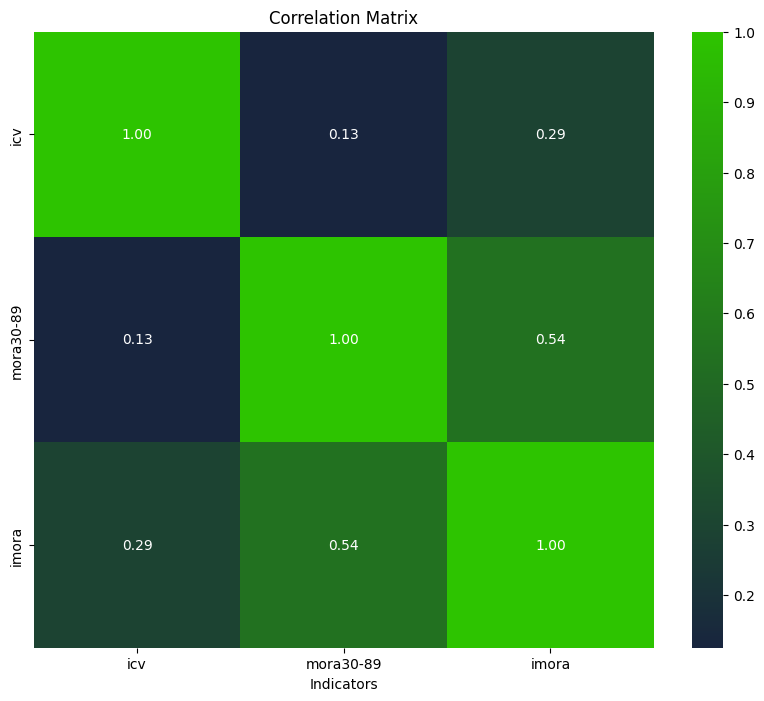

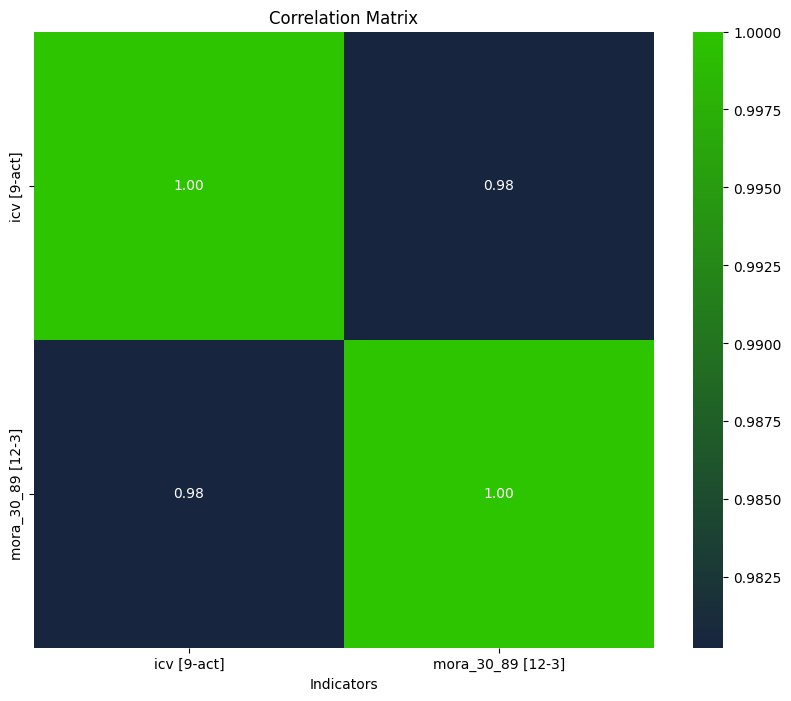

In [ ]:
def correlation_matrix_between_datasets(x):
    # Calculate the Pearson correlation coefficient for each pair of columns
    correlation_matrix = x.corr()

    # Convert the values to numeric
    correlation_matrix = correlation_matrix.astype(float)

    # Create a custom colormap from blue to green
    custom_cmap = LinearSegmentedColormap.from_list("blue_green", ["#18253e", "#2dc400"])

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap, cbar=True)
    plt.title("Correlation Matrix")
    plt.xlabel("Indicators")
    plt.show()

    return correlation_matrix

# Example usage
correlation_matrix = correlation_matrix_between_datasets(matrix)
correlation_matrix = correlation_matrix_between_datasets(matriz1)


### Sucursal Classification


#### New Indicators Normalization

- For indicator classification:
      (A) Low
      (B) Medium-Low
      (C) Medium-High
      (D) High
  

In [ ]:
def normalize(df):
    # Separar la columna 'sucursal' de las demás
    sucursal = df['sucursal']
    # Seleccionar solo las columnas numéricas que deseas normalizar
    numeric_df = df.drop(columns=['sucursal'])

    # Aplanar los datos para calcular la normalización globalmente
    x_flat = numeric_df.values.flatten().reshape(-1, 1)
    scaler = MinMaxScaler()
    x_normalizada = scaler.fit_transform(x_flat).reshape(numeric_df.shape)

    # Convertir la matriz normalizada de vuelta a un DataFrame con las columnas originales
    df_normalized = pd.DataFrame(x_normalizada, columns=numeric_df.columns)

    # Reinsertar la columna 'sucursal' sin cambios
    df_normalized.insert(0, 'sucursal', sucursal)

    return df_normalized

# Supongamos que 'adjusted_icv_df' y 'adjusted_imora_df' son tus DataFrames
Pts_icv = normalize(adjusted_icv_df)
Pts_imora = normalize(adjusted_imora_df)
Pts_mora = normalize(adjusted_mora_30_89_df)
# Mostrar los primeros resultados
Pts_icv.describe()

,icv12,icv11,icv10,icv9,icv8,icv7,icv6,icv5,icv4,icv3,icv2,icv1,icv_actual
count,169.000000,169.000000,170.000000,172.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,0.446507,0.452127,0.450248,0.447718,0.453809,0.435374,0.448257,0.450647,0.445650,0.422483,0.431308,0.441806,0.438045
std,0.210894,0.201926,0.188479,0.188632,0.200717,0.191692,0.204248,0.212679,0.195615,0.190368,0.178867,0.176824,0.171474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028381,0.035833,0.025778
25%,0.322530,0.325664,0.318800,0.332055,0.316794,0.308067,0.309749,0.304008,0.304217,0.288851,0.302049,0.308199,0.314923
50%,0.420403,0.428581,0.426433,0.417414,0.427547,0.415392,0.426639,0.420959,0.423612,0.389472,0.405157,0.418115,0.428144
75%,0.565395,0.553671,0.548070,0.558723,0.561900,0.555771,0.576437,0.582405,0.541804,0.521183,0.524152,0.549464,0.528085
max,0.929693,0.895683,0.891974,0.898727,0.929560,0.927326,0.976467,1.000000,0.898184,0.869682,0.857307,0.911362,0.847827


In [ ]:
print(Pts_icv.iloc[:,12])
#Prm.describe()

0      0.462137
1      0.255594
2      0.450515
3      0.306770
4      0.302587
         ...   
168    0.249480
169    0.324842
170    0.911362
171    0.582234
172    0.195712
Name: icv1, Length: 173, dtype: float64


In [ ]:
def weights_puntaje(df1,df2,df3, we1=6, we2=12, we3=8):

  df1=df1*we1
  df2=df2*we2
  df3=df3*we3
  df=df1+df2+df3
  return df

puntajes=weights_puntaje(Pts_icv.iloc[:,12],Pts_imora.iloc[:,12],Pts_mora.iloc[:,12])
puntajes=pd.DataFrame(puntajes, columns=['Puntos'])
puntajes.insert(0, Pts_icv.columns[0], Pts_icv.iloc[:, 0])
print(puntajes)

               sucursal     Puntos
0      Aceros del Norte  13.049991
1         Aguas Central   7.788347
2           Aguas Norte   9.986553
3       Alto de Chilpan   9.464299
4    Altos de Queretaro   8.988419
..                  ...        ...
168       Victoria Alta   8.134969
169     Victoria Sierra   9.642333
170       Villa Central  22.961615
171         Villa Norte  15.198897
172       Zapopan Plaza   9.880139

[173 rows x 2 columns]


In [ ]:
#sumar las filas
def prm (x,y,z):
  suma=x+y+z
  promedio=suma/3
  return promedio

Prm=prm(Pts_icv.iloc[:,12],Pts_imora.iloc[:,12],Pts_mora.iloc[:,12])


def asignar_puntos(df, col):
  max=df[col].max()
  maxfin=max/4
  def calcular_puntos_tend(v):
    if v >= maxfin*3 and v <= maxfin*4:
      return 'D'
    elif v <=maxfin*3  and v >= maxfin*2:
      return 'C'
    elif v <=maxfin*2 and v >=maxfin:
      return 'B'
    elif v <=maxfin and v >=0:
      return 'A'
    else:
      return 0
  df['Puts'] = df[col].map(calcular_puntos_tend)
  df_puntos = df[['Puts']]
  df_puntos.insert(0, df.columns[0], df.iloc[:, 0])
  return df_puntos


valores=asignar_puntos(puntajes, 'Puntos')
#GUARDAR DF
# valores.to_csv('INDICATORS_CLASS.csv', index=False)
print(valores)

               sucursal Puts
0      Aceros del Norte    C
1         Aguas Central    B
2           Aguas Norte    B
3       Alto de Chilpan    B
4    Altos de Queretaro    B
..                  ...  ...
168       Victoria Alta    B
169     Victoria Sierra    B
170       Villa Central    D
171         Villa Norte    C
172       Zapopan Plaza    B

[173 rows x 2 columns]


In [ ]:
# def scatter_plot_with_trend(df):
#     """
#     Genera un scatter plot con una línea de tendencia para cada fila en el DataFrame.

#     Parámetros:
#     df (DataFrame): DataFrame con las filas y columnas a graficar. La primera columna se usa como título de cada gráfica.
#     """
#     for index, row in df.iterrows():
#         plt.figure(figsize=(8, 6))

#         # Datos para la dispersión
#         x_values = range(1, len(row))
#         y_values = row[1:].astype(float)

#         # Graficar los puntos
#         plt.scatter(x_values, y_values, color='blue', label='Valores')

#         # Cálculo de la línea de tendencia
#         z = np.polyfit(x_values, y_values, 1)
#         p = np.poly1d(z)

#         # Graficar la línea de tendencia
#         plt.plot(x_values, p(x_values), color='red', linestyle='--', label='Tendencia')

#         # Título con el nombre de la primera columna en esa fila
#         plt.title(f'Gráfica de dispersión para la sucursal {row[0]}')

#         plt.xlabel('Columnas')
#         plt.ylabel('Valores')
#         plt.xticks(x_values, df.columns[1:], rotation=45)
#         plt.grid(True)
#         plt.legend()

#         plt.show()

# # Ejemplo de uso
# scatter_plot_with_trend(adjusted_icv_df)
# scatter_plot_with_trend(adjusted_imora_df)
# scatter_plot_with_trend(adjusted_mora_30_89_df)
#  # Llama a la función pasando tu DataFrame 'Data'

#### Trend Computation and Normalization

- For trends classification:
      (1) Decreasing trend ↓
      (2) Stable trend →
      (3) Increasing trend ↑

In [ ]:
def calcular_trends(df):
    """
    Calcula la pendiente de la línea de tendencia para cada fila en el DataFrame.

    Parámetros:
    df (DataFrame): DataFrame con las filas y columnas a analizar. La primera columna se usa como identificador de la fila.

    Retorna:
    DataFrame: Un nuevo DataFrame con la pendiente de la tendencia (slope) para cada fila.
    """
    trends = []

    for index, row in df.iterrows():
        x_values = range(1, len(row))
        y_values = row[1:].astype(float)

        # Cálculo de la pendiente de la línea de tendencia
        slope, _ = np.polyfit(x_values, y_values, 1)

        # Guardar la pendiente y el nombre de la sucursal
        trends.append({
            df.columns[0]: row.iloc[0],  # Nombre de la primera columna (e.g., 'sucursal')
            'tendencia': slope
        })

    # Convertir la lista de diccionarios en un DataFrame
    trends_df = pd.DataFrame(trends)

    return trends_df

# Compute trends for each indicator
trends_df_adjusted_mora_30_89_df = calcular_trends(adjusted_mora_30_89_df)
trends_df_adjusted_icv_df = calcular_trends(adjusted_icv_df)
trends_df_adjusted_imora_df = calcular_trends(adjusted_imora_df)

In [ ]:
# Codification of trends
def assign_trend(df):
    std = df['tendencia'].std()

    assign_df = df.copy(deep=True)
    assign_df['tendencia'] = assign_df['tendencia'].apply(lambda x: 1 if x > std else (0 if x < -std else 0.5))

    return assign_df

# Apply codification
mora_30_89_trend_coded = assign_trend(trends_df_adjusted_mora_30_89_df)
icv_trend_coded = assign_trend(trends_df_adjusted_icv_df)
imora_trend_coded = assign_trend(trends_df_adjusted_imora_df)

In [ ]:
# Multiply per wights and put toghether in a DataFrame
mora_30_89_trend_coded['tendencia'] = mora_30_89_trend_coded['tendencia'] / 6
icv_trend_coded['tendencia'] = icv_trend_coded['tendencia'] / 10
imora_trend_coded['tendencia'] = imora_trend_coded['tendencia'] / 15

# Merge the DataFrames on 'sucursal' before summing
merged_trends = mora_30_89_trend_coded[['sucursal', 'tendencia']].merge(
    icv_trend_coded[['sucursal', 'tendencia']],
    on='sucursal',
    suffixes=('_mora_30_89', '_icv')
).merge(
    imora_trend_coded[['sucursal', 'tendencia']],
    on='sucursal'
)

# Sum the tendencia values
final_trend = pd.DataFrame()
final_trend['sucursal'] = merged_trends['sucursal']
final_trend['tendencia'] = (
    merged_trends['tendencia_mora_30_89'] +
    merged_trends['tendencia_icv'] +
    merged_trends['tendencia']
)

# Determine the min and max of the summed tendencia
min_value = final_trend['tendencia'].min()
max_value = final_trend['tendencia'].max()

# Classify tendencia values into 3 bins based on the min, max, and number of bins
final_trend['tendencia'] = pd.cut(
    final_trend['tendencia'],
    bins=3,
    labels=[1, 2, 3],
    include_lowest=True
)

# # Save
# final_trend.to_csv('trend_class.csv', index=False)

#### Final Classification

For sucursal classification:

    (1) Top-Tier Sucursal [A1, A2]
    (2) Good-Performance Sucursal [B1, B2, A3]
    (3) Medium-Risk Sucursal [C1, C2, B3]
    (4) High-Risk (or Monitored Sucursal) [D1,D2,C3,D3]
    (5) Emerging Sucursal (for new branches)
    (6) Dormant Sucursal (for inactive branches)

In [ ]:
# Example function to assign sucursal class
def assign_final_class(row):
    if row['Puts'] == 'A' and row['tendencia'] in [1, 2]:
        return 1  # Top-Performing Sucursal
    elif (row['Puts'] == 'B' and row['tendencia'] in [1, 2]) or (row['Puts'] == 'A' and row['tendencia'] == 3):
        return 2  # High-Performing Sucursal
    elif (row['Puts'] == 'C' and row['tendencia'] in [1, 2]) or (row['Puts'] == 'B' and row['tendencia'] == 3):
        return 3  # Moderate-Performing Sucursal
    elif (row['Puts'] == 'D' and row['tendencia'] in [1, 2, 3]) or (row['Puts'] == 'C' and row['tendencia'] == 3):
        return 4  # Under Observation Sucursal (Monitored Sucursal)
    else:
        return None  # If no match, return None (or you can choose a default class)

# Assuming 'valores' and 'final_trend' are your initial DataFrames, here's how you can apply the function
final_class = pd.DataFrame()
final_class['sucursal'] = valores['sucursal']

# Merge the dataframes on 'sucursal'
final_class = final_class.merge(valores, on='sucursal', how='left')
final_class = final_class.merge(final_trend, on='sucursal', how='left')

# Apply the function to assign the sucursal class
final_class['sucursal_class'] = final_class.apply(assign_final_class, axis=1)

# Display the final DataFrame with the assigned classes
final_class


,sucursal,Puts,tendencia,sucursal_class
0,Aceros del Norte,C,2,3
1,Aguas Central,B,2,2
2,Aguas Norte,B,2,2
3,Alto de Chilpan,B,1,2
4,Altos de Queretaro,B,2,2
...,...,...,...,...
168,Victoria Alta,B,2,2
169,Victoria Sierra,B,2,2
170,Villa Central,D,2,4
171,Villa Norte,C,2,3


## Load


### Aconditionate New and Inactive Sucursals

In [ ]:
# Add 'sucursal_class' column with value 5 to new_sucursals
new_sucursals.loc[:,'sucursal_class'] = 5

# Add 'sucursal_class' column with value 6 to inactive_sucursals
inactive_sucursals.loc[:,'sucursal_class'] = 6

# Concatenate the two DataFrames
aux = pd.concat([new_sucursals[['sucursal', 'sucursal_class']], inactive_sucursals[['sucursal', 'sucursal_class']]])

# Apply the function to create new columns
aux['region'], aux['division'] = zip(*aux['sucursal'].apply(extract_region_division, args=(loc_struct,)))
# Insert 'region' as the first column
aux.insert(0, 'region', aux.pop('region'))
# Insert 'division' as the second column
aux.insert(1, 'division', aux.pop('division'))

# Merge locations to old_active_sucursals_df
aux = aux.merge(locations_df, on='sucursal', how='left')

# Display the resulting DataFrame
aux

<ipython-input-40-495ccfa4382e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_sucursals.loc[:,'sucursal_class'] = 5
<ipython-input-40-495ccfa4382e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_sucursals.loc[:,'sucursal_class'] = 6


,region,division,sucursal,sucursal_class,ubicacion,Country,State,City
0,Red Sureste,Zona Riviera del Caribe,Alturas Merida,5,"21.02, -89.63",Mexico,Yucatán,Mérida
1,Nucleo Dos,Nucleo Avance,Avance 4,5,"19.433, -99.137",Mexico,Ciudad de México,Ciudad de México
2,Red Nortena,Zona Bahia del Sol,Bahia Aeropuerto,5,"22.28, -97.87",Mexico,Tamaulipas,Tampico
3,Red Nortena,Zona Sierra Norte,Bulevar Regio,5,"25.68, -100.32",Mexico,Nuevo León,Monterrey
4,Nucleo Dos,Zona Oriente Conexion,Campo Florido C,5,"19.38, -99.04",Mexico,Ciudad de México,Ciudad de México
5,Nucleo Dos,Zona Oriente Conexion,Campo Florido D,5,"19.385, -99.0425",Mexico,Ciudad de México,Ciudad de México
6,Nucleo Dos,Division. Distrito Central,Colinas GAM,5,"19.51, -99.12",Mexico,Ciudad de México,Ciudad de México
7,Occidente Conexion,Conexion GDL,Guadalajara Dos,5,"20.675, -103.34",Mexico,Jalisco,Guadalajara
8,Occidente Conexion,Conexion GDL,Guadalajara Tres,5,"20.665, -103.36",Mexico,Jalisco,Guadalajara
9,Occidente Conexion,Conexion GDL,Guadalajara Uno,5,"20.67, -103.35",Mexico,Jalisco,Guadalajara


### Merge everything into final .csv

In [ ]:
# Create final Dataframe
output = filtered_df.iloc[:, :8]

# Merge Classifications columns
output = output.merge(final_class, on='sucursal', how='left')

# Rename columns
output.rename(columns={'Puts': 'indic_class', 'tendencia': 'trend'}, inplace=True)

# Add act new indicators
dumb = pd.DataFrame({'sucursal': adjusted_mora_30_89_df['sucursal'], 'mora_30_89_act': adjusted_mora_30_89_df['mora_actual']})
output = output.merge(dumb, on='sucursal', how='left')
dumb = pd.DataFrame({'sucursal': adjusted_imora_df['sucursal'], 'imora_act': adjusted_imora_df['imora_actual']})
output = output.merge(dumb, on='sucursal', how='left')
dumb = pd.DataFrame({'sucursal': adjusted_icv_df['sucursal'], 'icv_act': adjusted_icv_df['icv_actual']})
output = output.merge(dumb, on='sucursal', how='left')

# Drop amount of vendors
output.drop(columns=['vendor_count'], inplace=True)

# Add new and inactive sucursals
output = pd.concat([output, aux])

# Save final df
output.to_csv('Indicadores_reto_AD24_final.csv', index=False)

# Show final df
output

,region,division,sucursal,ubicacion,Country,State,City,indic_class,trend,sucursal_class,mora_30_89_act,imora_act,icv_act
0,Red Nortena,Division Red Nortena,Aceros del Norte,"26.92, -100.32",Mexico,Nuevo León,El Armadillo,C,2,3,5.898962,17.187933,8.958551
1,Occidente Conexion,Zona Corazon de la Sierra,Aguas Central,"21.88, -102.29",Mexico,Aguascalientes,Aguascalientes,B,2,2,3.863528,10.825664,4.473375
2,Occidente Conexion,Zona Corazon de la Sierra,Aguas Norte,"21.9, -102.3",Mexico,Aguascalientes,Aguascalientes,B,2,2,5.060178,13.560583,6.473627
3,Nucleo Uno,Zona Sur Central,Alto de Chilpan,"19.5565, -99.2133",Mexico,Estado de México,Tlalnepantla,B,1,2,4.165036,16.172568,4.014747
4,Nucleo Uno,Division. Red Mexiquense,Altos de Queretaro,"19.53, -99.21",Mexico,Estado de México,Tlalnepantla,B,2,2,5.529333,11.774125,5.129226
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,Red Sureste,Zona Selva Alta,Villa Alturas,"17.73, -91.77",Mexico,Tabasco,Emiliano Zapata,NaN,NaN,5,NaN,NaN,NaN
18,Brokers,None,Centro Metropolis,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN
19,Brokers,None,Conexion Magna,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN
20,Brokers,None,Enlace Regio,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN


In [ ]:
output.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 21
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   region          196 non-null    object  
 1   division        192 non-null    object  
 2   sucursal        196 non-null    object  
 3   ubicacion       183 non-null    object  
 4   Country         183 non-null    object  
 5   State           183 non-null    object  
 6   City            183 non-null    object  
 7   indic_class     174 non-null    object  
 8   trend           174 non-null    category
 9   sucursal_class  196 non-null    int64   
 10  mora_30_89_act  174 non-null    float64 
 11  imora_act       174 non-null    float64 
 12  icv_act         174 non-null    float64 
dtypes: category(1), float64(3), int64(1), object(8)
memory usage: 20.2+ KB


## Extra information


This section is dedicated to know what stadistics or special amounts so we can include them into our presentation and report.


Get the size of our Universe

In [ ]:
def count_vendors_new_inactive(new_branch, inactive_branch, vendor_count):
  # Count the vendedors inside new branches and inactive branches
  new_count = 0
  inactive_count = 0

  for index, row in vendor_count.iterrows():
    if row['sucursal'] in list(new_branch['sucursal']):
      new_count += row['vendor_count']
    elif row['sucursal'] in list(inactive_branch['sucursal']):
      inactive_count += row['vendor_count']

  return new_count, inactive_count

new_count, inactive_count = count_vendors_new_inactive(new_sucursals, inactive_sucursals, vendor_count)

print("Number of vendors in new branches:", new_count)
print("Number of vendors in inactive branches:", inactive_count)
print("Number of vendors in old-active branches:", (vendor_count['vendor_count'].sum()-new_count-inactive_count))

Number of vendors in new branches: 203
Number of vendors in inactive branches: 7
Number of vendors in old-active branches: 9838


Get the 1 porcentual point significance of decreasing 1pp the mora_30_89

1pp difference in imora after mora_30_89: -18.44 %
mora 30 89 from 5.42% to 4.42%
imora from 17.39% to 14.18%


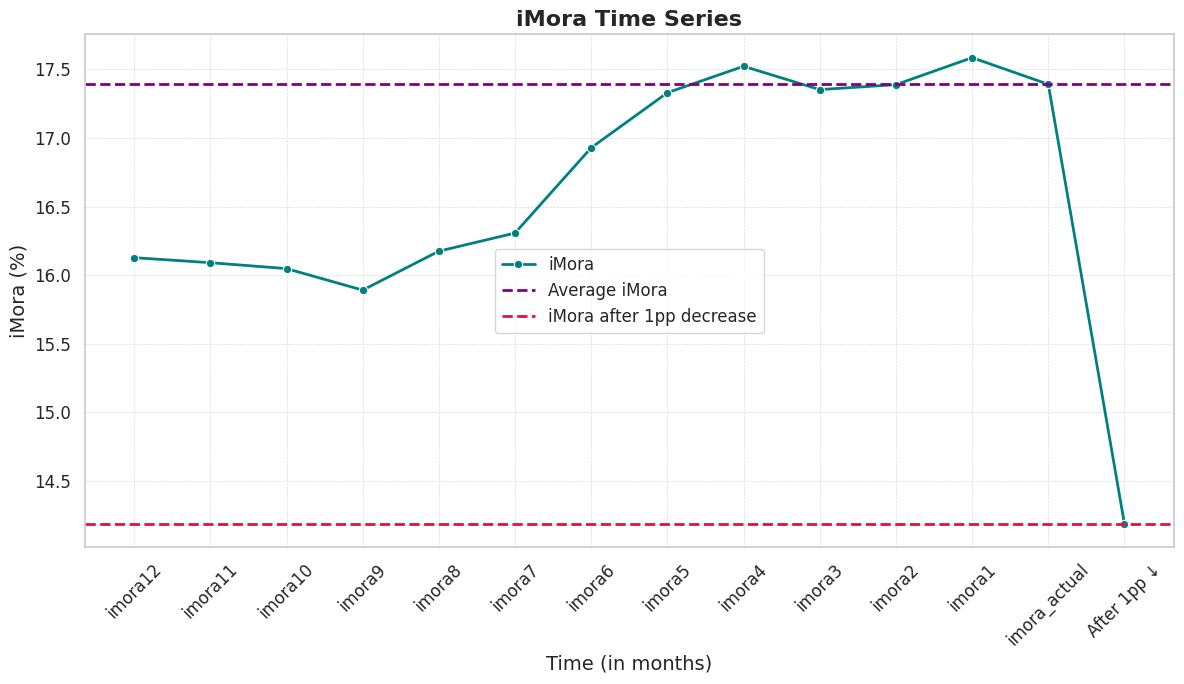

In [ ]:
# Get average current value of new indicators
mora_30_89_avg = adjusted_mora_30_89_df['mora_actual'].mean()
imora_avg = adjusted_imora_df['imora_actual'].mean()
icv_avg = adjusted_icv_df['icv_actual'].mean()

# What happen by decreasing 1pp
mora_30_89_avg_1pp = mora_30_89_avg - 1
icv_avg_1pp = (icv_avg / mora_30_89_avg) * mora_30_89_avg_1pp
imora_avg_1pp = (imora_avg / icv_avg) * icv_avg_1pp

# Porcentual difference
mora_30_89_avg_1pp_perc = ((mora_30_89_avg_1pp / mora_30_89_avg) - 1) * 100
print("1pp difference in imora after mora_30_89:", round(mora_30_89_avg_1pp_perc, 2), '%')

# Translation
print(f"mora 30 89 from {round(mora_30_89_avg, 2)}% to {round(mora_30_89_avg_1pp, 2)}%")
print(f"imora from {round(imora_avg, 2)}% to {round(imora_avg_1pp, 2)}%")

# See how we can get money back
cols = adjusted_imora_df.iloc[:,1:].columns

# Calculate the average values of 'imora' over time
imora_avgs = [adjusted_imora_df[col].mean() for col in adjusted_imora_df.iloc[:,1:].columns]

# Adding the final imora after a 1pp decrease
imora_avgs.append(imora_avg_1pp)
time_index = list(adjusted_imora_df.iloc[:,1:].columns) + ["After 1pp ↓"]

# Time serie of imora
# Set a Seaborn style
sns.set(style="whitegrid")

# Plot with Seaborn
plt.figure(figsize=(12, 7))
sns.lineplot(x=time_index, y=imora_avgs, marker='o', color='teal', linewidth=2, label='iMora')

# Adding horizontal lines for average and 1pp decrease
plt.axhline(y=imora_avg, color='purple', linestyle='--', linewidth=2, label='Average iMora')
plt.axhline(y=imora_avg_1pp, color='crimson', linestyle='--', linewidth=2, label='iMora after 1pp decrease')

# Title and labels
plt.title('iMora Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Time (in months)', fontsize=14)
plt.ylabel('iMora (%)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a tight layout to avoid overlapping
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import plotly.graph_objects as go

# Create the plotly figure
fig = go.Figure()

# Add the iMora line
fig.add_trace(go.Scatter(
    x=time_index, y=imora_avgs,
    mode='lines+markers',
    name='iMora',
    line=dict(color='teal', width=4),
    marker=dict(size=8)
))

# Add the average and 1pp decrease lines
fig.add_trace(go.Scatter(
    x=[time_index[0], time_index[-1]], y=[imora_avg, imora_avg],
    mode='lines',
    name='Average iMora',
    line=dict(color='purple', width=2, dash='dash')
))
fig.add_trace(go.Scatter(
    x=[time_index[0], time_index[-1]], y=[imora_avg_1pp, imora_avg_1pp],
    mode='lines',
    name='iMora after 1pp decrease',
    line=dict(color='green', width=2, dash='dash')
))

# Update layout for a prettier appearance
fig.update_layout(
    title='iMora Time Series',
    xaxis_title='Time (in months)',
    yaxis_title='iMora (%)',
    font=dict(size=14),
    legend=dict(font=dict(size=12)),
    plot_bgcolor='white'
)

# Show the plot
fig.show()
